In [410]:
from bs4 import BeautifulSoup
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [411]:
def parse_report_folder(folder):
    p = Path(folder)
    versions = [f.name for f in p.iterdir() if f.is_dir()]
    tests = []
    for version in versions:
        p = Path(f"{reports_location}{version}")
        runs = [f.name for f in p.iterdir() if f.is_dir()]
        for run in runs:
            pc = Path(f"{reports_location}{version}/{run}/classes/")
            classes = [f.name for f in pc.iterdir()]
            for class_test in classes:
                with open(f"{reports_location}{version}/{run}/classes/{class_test}") as fp:
                    soup = BeautifulSoup(fp)
                    #print(soup.prettify())

                test_table = soup.find_all('table')[2]
                data = test_table.find_all("tr")

                for row in range(1,len(data)):
                    tests.append((version, run, class_test,
                                  data[row].find_all("td")[0].string,
                                np.NaN if data[row].find_all("td")[1].string == "-" else data[row].find_all("td")[1].string.replace("s", ""),
                                data[row].find_all("td")[2].string))
    #Create dataframe
    results = pd.DataFrame(tests, columns=["Tag", "Run", "Class", "Test", "Time", "Status"])
    results.Time = results.Time.astype("float64")
    results.Run = results.Run.astype("int64")
    
    return results

## All tests analysis

In [412]:
reports_location = "/Users/alexincerti/Code/test_results/"

In [413]:
results = parse_report_folder(reports_location)
results.shape

(30476, 6)

In [414]:
results.head()

,Tag,Run,Class,Test,Time,Status
0,v7.7.0,0,org.elasticsearch.search.aggregations.bucket.t...,testEqualsAndHashcode,0.030,passed
1,v7.7.0,0,org.elasticsearch.search.aggregations.bucket.t...,testFromXContent,0.004,passed
2,v7.7.0,0,org.elasticsearch.search.aggregations.bucket.t...,testFromXContentWithRandomFields,0.021,passed
3,v7.7.0,0,org.elasticsearch.search.aggregations.bucket.t...,testIterators,0.008,passed
4,v7.7.0,0,org.elasticsearch.search.aggregations.bucket.t...,testReduceRandom,0.014,passed


In [415]:
agg = results.groupby(["Tag","Class", "Test", "Status"]).mean().Time.reset_index()

In [416]:
agg.head()

,Tag,Class,Test,Status,Time
0,v7.7.0,org.elasticsearch.search.ClearScrollResponseTe...,testToAndFromXContent,passed,0.00800
1,v7.7.0,org.elasticsearch.search.ClearScrollResponseTe...,testToXContent,passed,0.00575
2,v7.7.0,org.elasticsearch.search.DefaultSearchContextT...,testPreProcess,passed,0.24225
3,v7.7.0,org.elasticsearch.search.DocValueFormatTests.html,testBinaryFormat,passed,0.01125
4,v7.7.0,org.elasticsearch.search.DocValueFormatTests.html,testBooleanFormat,passed,0.08200


#### Number of unique tests in each version
The number increases as it would be expected as new tests get added incrementally

In [417]:
results.groupby("Tag").Test.nunique()

Tag
v7.7.0    816
v7.7.1    816
v7.8.0    863
v7.8.1    864
Name: Test, dtype: int64

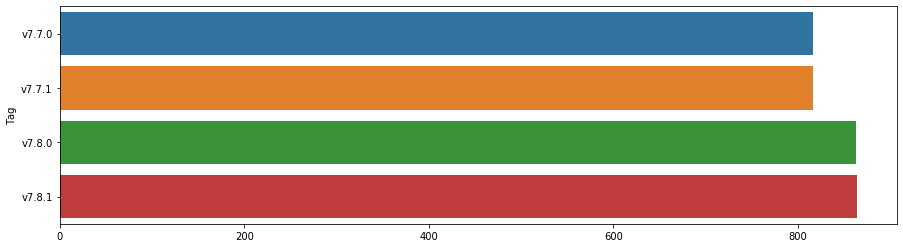

In [418]:
plt.figure(figsize=(15,4))
sns.barplot(results.groupby("Tag").Test.nunique().values, results.groupby("Tag").Test.nunique().index)

#### Number of runs per each version
Just a check to see if all versions have been run the same and expected number of times

In [419]:
results.groupby(["Tag"]).Run.nunique()

Tag
v7.7.0    4
v7.7.1    4
v7.8.0    4
v7.8.1    4
Name: Run, dtype: int64

#### Number of passed/ignored per each version
As the number of tests increseas, so does the number of passed.

Important to keep an eye on the development of ignored tests, as marking tests as "to ignore" can be used as a quick fix to hide outdated and failing tests

In [420]:
ign_pass = results.groupby(["Tag", "Status"]).nunique().Test.reset_index()
ign_pass = ign_pass.rename(columns={"Test": "Count"})
ign_pass

,Tag,Status,Count
0,v7.7.0,ignored,1
1,v7.7.0,passed,816
2,v7.7.1,ignored,1
3,v7.7.1,passed,816
4,v7.8.0,ignored,1
5,v7.8.0,passed,863
6,v7.8.1,ignored,1
7,v7.8.1,passed,864


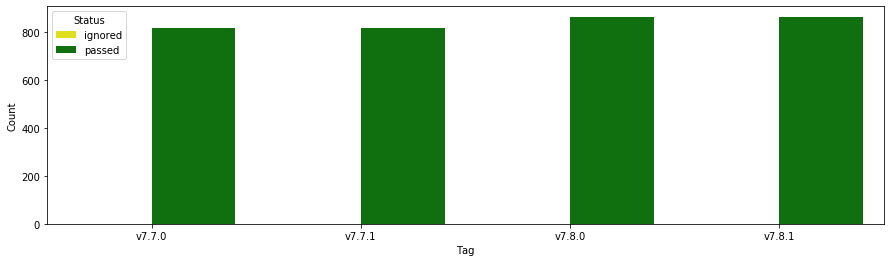

In [421]:
plt.figure(figsize=(15,4))
sns.barplot(x="Tag", y="Count", hue="Status", data=ign_pass, palette={"failed":"red",
                                                                      "ignored":"yellow",
                                                                      "passed":"green"})

#### Tests with highest difference between max and min running time
Some tests present a very high difference of average running time.<br/>
Average can be misleading and therefore when plotting these test results, we plot all the values from each version.

In [422]:
tests_to_plot = (agg.groupby("Test").Time.max() - agg.groupby("Test").Time.min()).sort_values(ascending=False).head(10).index
tests_to_plot

Index(['testMerge', 'testMatchAllDocs', 'testBiggest', 'testRandom',
       'testMatchSparse', 'testManyDocsOneRare', 'testNeedsScores',
       'testMatchSparseRangeField', 'testParsingQueryContextGeoPoint',
       'testMatchNoDocs'],
      dtype='object', name='Test')

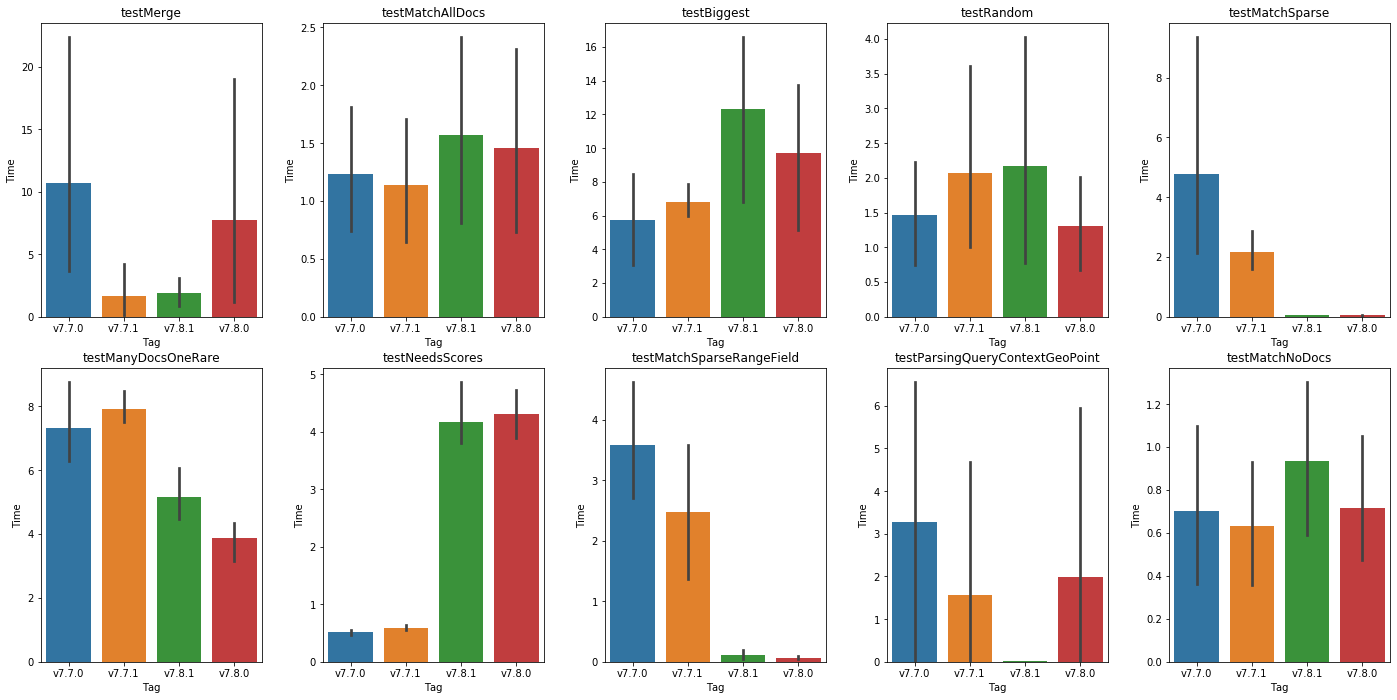

In [423]:
cols = int(len(tests_to_plot)/2)
fig, axes = plt.subplots(2, cols, figsize=(20,10))
fig.tight_layout(pad=3.0)
for i, test in enumerate(tests_to_plot):
    ax = sns.barplot(ax=axes[int(i/(cols))][i%cols], x="Tag", y="Time", data = results[results.Test == test])
    ax.set_title(test)

This way we could get a visual bar expressing the confidence for the height of the bar.<br/>
This allowed to indeed identify some tests whose performance consistently improved or decreased over time, and some which did not and most likely had their avarage running time biad by one single very slow run.

## 30 runs of package analysis
We ran the tests from the package "search.aggregations.bucket" 30 times for each version to analyze outliers and performance

In [424]:
reports_location = "/Users/alexincerti/Code/search.aggregations.bucket/"

In [425]:
results = parse_report_folder(reports_location)
results.shape

(1740, 6)

#### Number of unique tests in each version
The number increases as it would be expected as new tests get added incrementally

In [426]:
results.groupby("Tag").Test.nunique()

Tag
v7.7.0    10
v7.7.1    10
v7.8.0    19
v7.8.1    19
Name: Test, dtype: int64

#### Number of runs per each version
Just a check to see if all versions have been run the same and expected number of times

In [427]:
results.groupby(["Tag"]).Run.nunique()

Tag
v7.7.0    30
v7.7.1    30
v7.8.0    30
v7.8.1    30
Name: Run, dtype: int64

Let's plot all the tests and their running time throughout the tags

In [428]:
tests_to_plot = results.Test.unique()

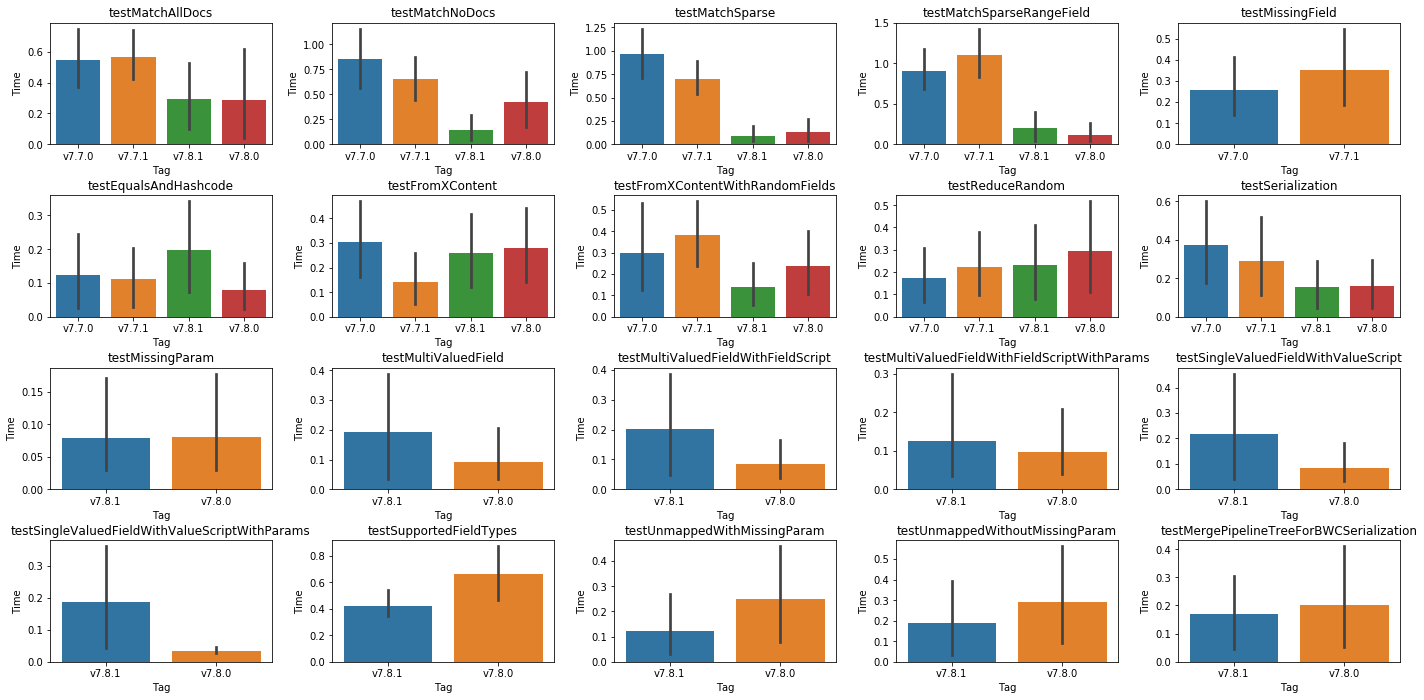

In [429]:
rows= 4
cols = int(len(tests_to_plot)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(20,10))
fig.tight_layout(pad=3.0)
for i, test in enumerate(tests_to_plot):
    ax = sns.barplot(ax=axes[int(i/(cols))][i%cols], x="Tag", y="Time", data = results[results.Test == test])
    ax.set_title(test)

**testMatchSparseRangeField** seems to show a trend of improving performance over the tags, as we had noticed in the previous analysis. Let's look a bit closer by plotting the running times of each run.

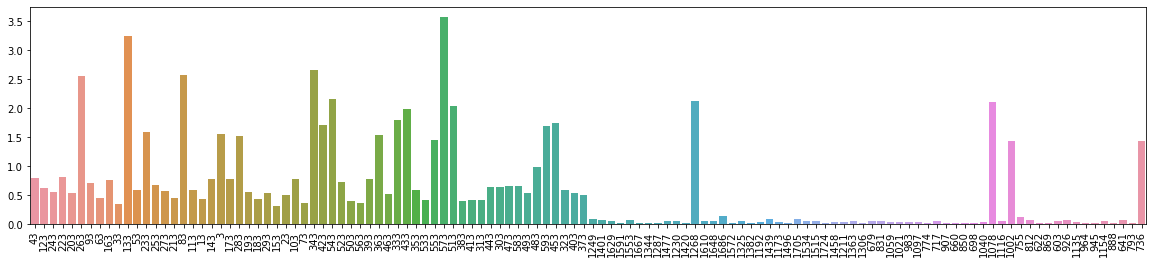

In [430]:
plt.figure(figsize=(20,4))
data = results[results.Test == 'testMatchSparseRangeField'].sort_values(by=["Tag", "Run"])
ax=sns.barplot(x=data.index, y=data.Time.values, order=data.index)
ax.tick_params(axis='x', labelrotation= 90)

**1268** seems to be an outlier among the close runs

In [431]:
data.loc[1268]

Tag                                                  v7.8.0
Run                                                      11
Class     org.elasticsearch.search.aggregations.bucket.m...
Test                              testMatchSparseRangeField
Time                                                  2.117
Status                                               passed
Name: 1268, dtype: object

We have seen that **run 11** of **v7.8.0** has been oddly slower than the others. Investigate which run of v7.8.0 has been slower and if that has been the case for other tests other than testMatchSparseRangeField

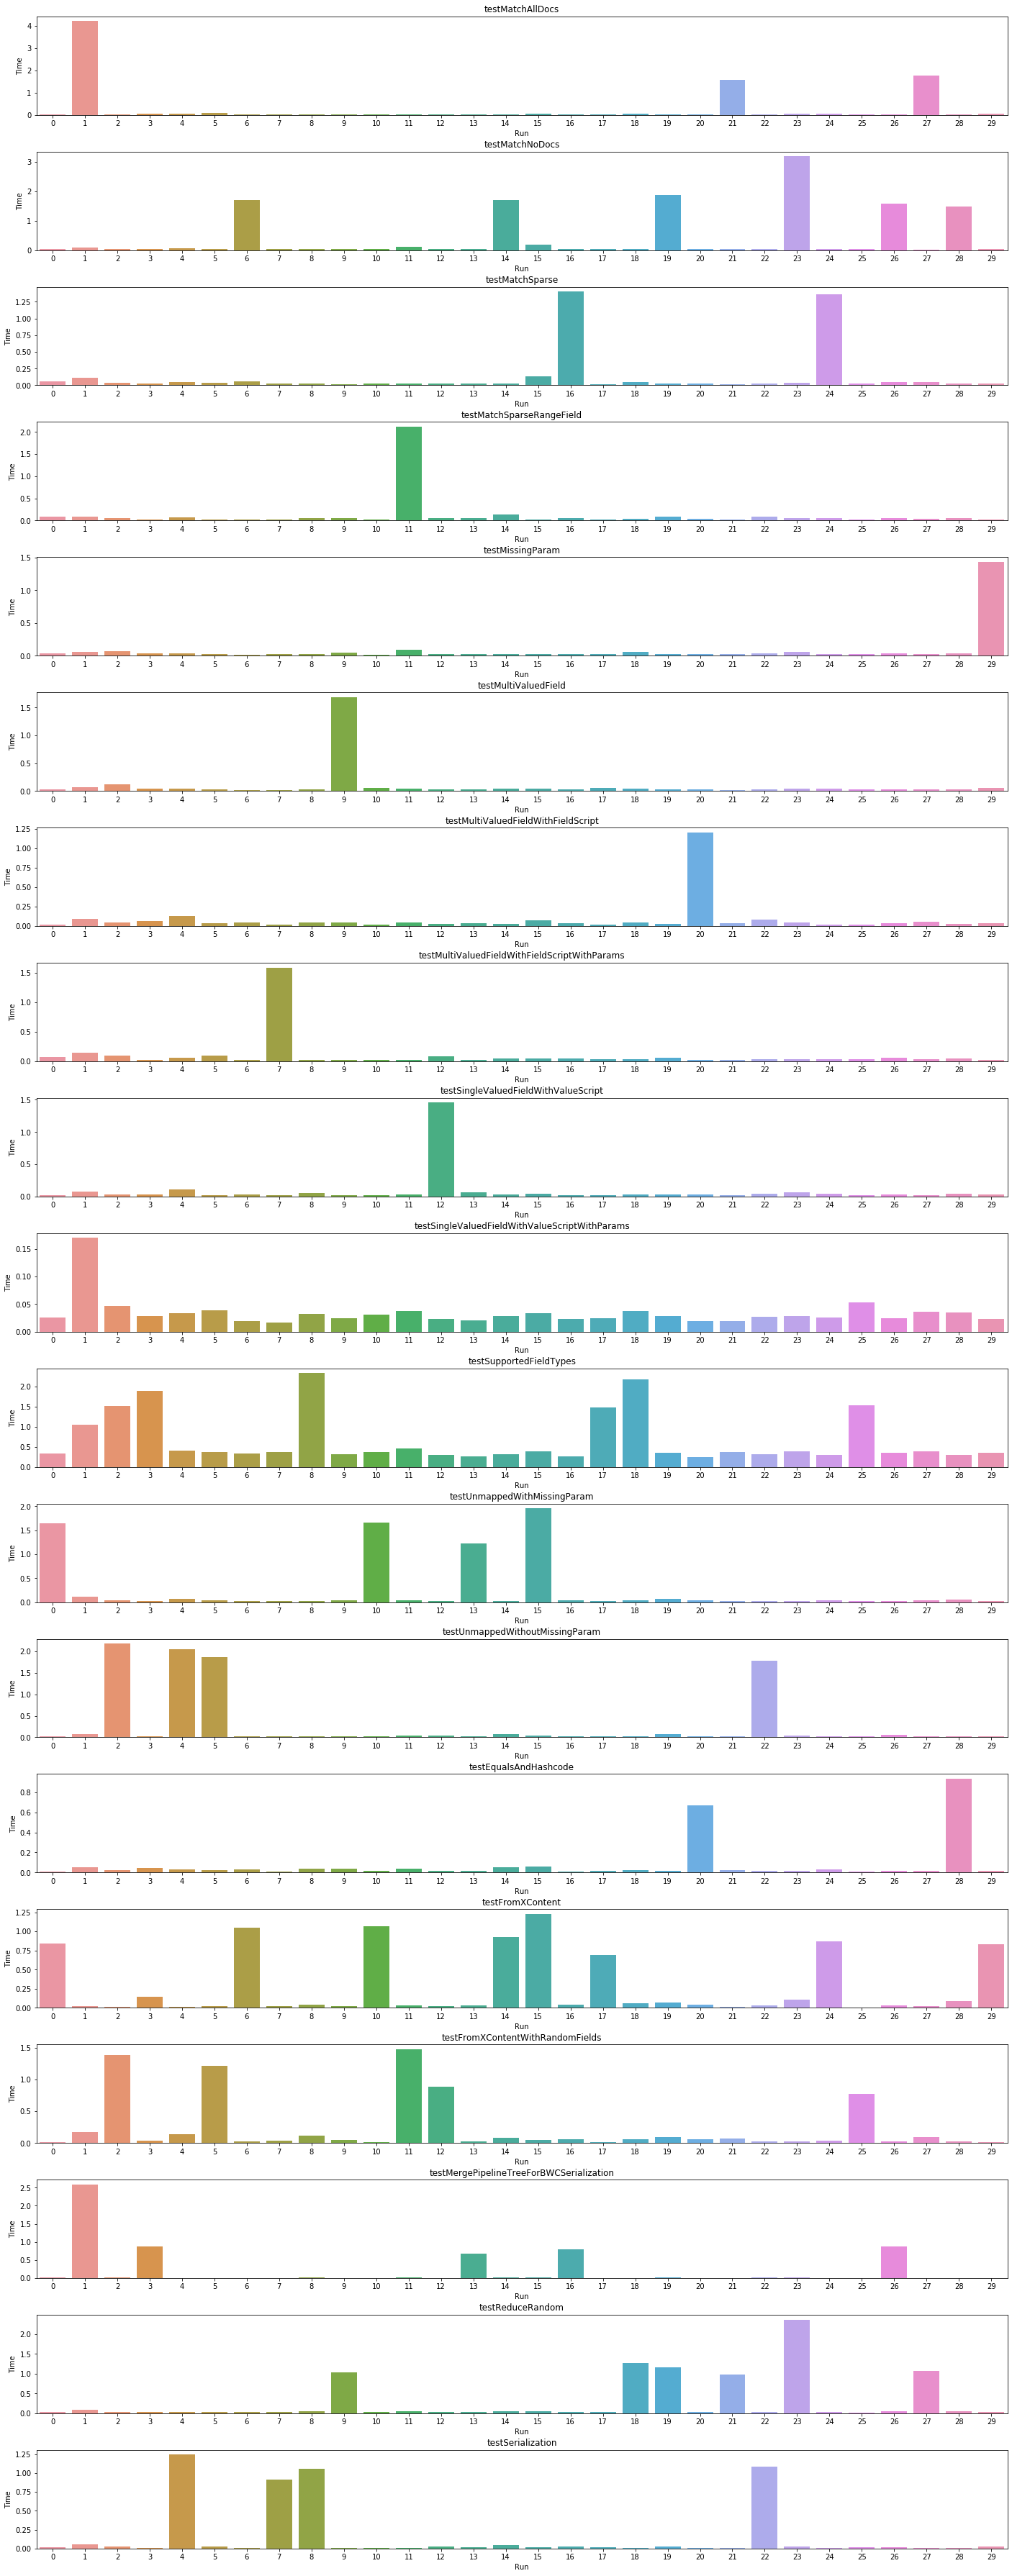

In [439]:
tests_to_plot = results[results.Tag=="v7.8.0"].Test.unique()
rows = len(tests_to_plot)
fig, axes = plt.subplots(rows, figsize=(20,50))
fig.tight_layout(pad=3.0)
for i, test in enumerate(tests_to_plot):
    data = results[(results.Tag=="v7.8.0") & (results.Test == test)]
    ax = sns.barplot(ax=axes[i], x="Run", y="Time", data=data)
    ax.set_title(test)

There is nothing specifically odd about run 11. Other runs have shown oddly slower running times for other tests. This is probably due to other processes running in the os which slow down the test running in that moment. **This highlights the need of running tests multiple times to mitigate these phenomenon**